# Imports and Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import gan_protein_structural_requirements.utils as utils
from gan_protein_structural_requirements.utils.protein_visualizer import jupy_viz_obj as jvo, jupy_viz_file as jvf
from gan_protein_structural_requirements.utils.folding_models import esm_batch_predict as esm_batch_predict, esm_predict as esm_predict, load_tokenizer as load_tokenizer
from gan_protein_structural_requirements.utils.extract_structure import extract_structures as extract_structures, untokenize as untokenize, get_untokenizer as get_untokenizer
from gan_protein_structural_requirements.data import class_protein_dataset as cpd
import pandas as pd
import matplotlib.pyplot as plt

# Data Analysis

In [3]:
dtst = cpd.Protein_dataset(
    root_dir="/Users/rohitkulkarni/Documents/gan_protein_structural_requirements/gan_protein_structural_requirements/data/raw/train",
    path_to_esm="/Users/rohitkulkarni/Documents/gan_protein_structural_requirements/gan_protein_structural_requirements/utils/esmfoldv1"
    )

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/Bio/PDB/DSSP.py:199: UserWarning: no atoms read before TER record 
TER    8879      TYR F1006                                                      
no atoms read before TER record 
TER    8947      TYR H1006                                                      
no atoms read before TER record 
TER    9015      TYR J1006                                                      
no atoms read before TER record 
TER    9083      TYR L1006                                                      

  warnings.warn(err)
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/Bio/PDB/DSSP.py:199: UserWarning: DSSP could not be created due to an error:
empty protein, or no valid complete residues

  warnings.warn(err)
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/Bio/PDB/DSSP.py:199: UserWarning: DSSP could not be created due to an error:
empty protein, or no val

## Get Pandas DataFrame

In [4]:
data = {"alpha helix":[],"isolated beta-bridge residue":[],"strand":[],"3-10 helix":[],"pi helix":[],"turn":[],"bend":[],"none":[],"polarity proportion":[],"sequence":[]}
for entry in dtst.X:
    data["alpha helix"].append(entry[0])
    data["isolated beta-bridge residue"].append(entry[1])
    data["strand"].append(entry[2])
    data["3-10 helix"].append(entry[3])
    data["pi helix"].append(entry[4])
    data["turn"].append(entry[5])
    data["bend"].append(entry[6])
    data["none"].append(entry[7])
    data["polarity proportion"].append(entry[8])
for entry in dtst.Y:
    data["sequence"].append(entry.tolist())

raw_data = pd.DataFrame(data)

array([<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
       <Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
       <Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
       <Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
       <Axes: ylabel='Density'>], dtype=object)

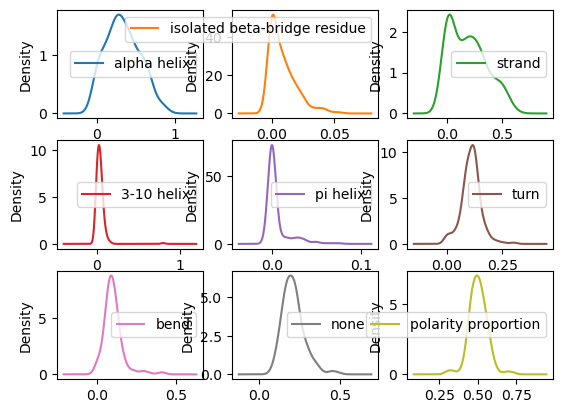

In [15]:
raw_features = raw_data.drop(columns=["sequence"])
fig, axes = plt.subplots(nrows=3, ncols=3)
raw_features.plot.kde(subplots=True, ax=axes)

In [17]:
raw_features.describe()

,alpha helix,isolated beta-bridge residue,strand,3-10 helix,pi helix,turn,bend,none,polarity proportion
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,0.334118,0.008634,0.188820,0.039075,0.005074,0.109650,0.103096,0.211532,0.502225
std,0.212848,0.010672,0.165355,0.065589,0.012656,0.043894,0.062048,0.067368,0.059551
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080000,0.300000
25%,0.177057,0.000000,0.030753,0.000000,0.000000,0.087432,0.069608,0.167375,0.465152
50%,0.313677,0.006171,0.169982,0.031305,0.000000,0.111725,0.093821,0.203660,0.500000
75%,0.485995,0.014139,0.303345,0.052114,0.000000,0.131171,0.123571,0.241428,0.538221
max,0.846154,0.053241,0.597015,0.800000,0.074074,0.300000,0.419355,0.486486,0.729730


Worst Features/skewed features - isolated beta-bridge residue, strand, 3-10 helix, and pi helix